## Скачивание данных для тренировки модели

#### Подключение к собственному Google Drive

In [ ]:
"""
Для воспроизведения кода на Вашем компьютере, 
запускать ячейку НЕ НУЖНО. Достаточно загрузить 
в локальное хранилище блокнота архив train.zip
"""


from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Распаковка архива с изображениями для тренировки модели из Google drive в локальное хранилище блокнота Сolab 

In [ ]:
"""
Для воспроизведения кода на Вашем компьютере, 
закомментировать следующую строчку
"""

!unzip gdrive/My\ Drive/data/Diploma\ ML-mid/train.zip

"""
Для воспроизведения кода на Вашем компьютере, 
убрать комментарий со следующей строчки
"""

# !unzip train.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/happy/3621.jpg    
  inflating: train/happy/3622.jpg    
  inflating: train/happy/3623.jpg    
  inflating: train/happy/3624.jpg    
  inflating: train/happy/3625.jpg    
 extracting: train/happy/3626.jpg    
  inflating: train/happy/3627.jpg    
  inflating: train/happy/3628.jpg    
  inflating: train/happy/3629.jpg    
  inflating: train/happy/363.jpg     
  inflating: train/happy/3630.jpg    
  inflating: train/happy/3631.jpg    
  inflating: train/happy/3632.jpg    
  inflating: train/happy/3633.jpg    
  inflating: train/happy/3634.jpg    
  inflating: train/happy/3635.jpg    
  inflating: train/happy/3636.jpg    
  inflating: train/happy/3637.jpg    
  inflating: train/happy/3638.jpg    
  inflating: train/happy/3639.jpg    
  inflating: train/happy/364.jpg     
  inflating: train/happy/3640.jpg    
  inflating: train/happy/3641.jpg    
  inflating: train/happy/3642.jpg    
  inflating: train/h

## Подготовка тренировочной и валидационной выборок

#### Импорт библиотек для подготовки тренировочной и валидационной выборок изображений и определения директории с данными

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 100
IMG_SHAPE  = 128 

dir = Path("train")

#### Так как используется подход fine tuning на уже готовой архитектуре VGG19, нужно импортировать соответствующую функцию предобработки изображений. Также используется аугментация данных (метод увеличения разнообразия обучающего набора путем применения случайных реалистичных преобразований)

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input, # препроцессинг
                               validation_split=0.2, # размер валидационной выборки, так как всё берётся из одной папки
                               rotation_range=40,  # максимальный угол поворота
                               width_shift_range=0.2, # смещение максимум на 20% ширины по горизонтали
                               height_shift_range=0.2, # смещение максимум на 20% высоты по вертикали
                               zoom_range=0.2, # картинка будет увеличена или уменьшена не более чем на 20%
                               horizontal_flip=True, # случайное отражение по горизонтали
                               fill_mode="nearest") # чем заполнять пробелы

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE, # размер батча  
                                               directory=dir, # директория для доступа к изображениям
                                               shuffle=True, # перемешивать ли данные 
                                               target_size=(IMG_SHAPE,IMG_SHAPE), # размер изображения
                                               class_mode="categorical", # тип классового распределения
                                               subset = "training") # указываем, что данная выборка тренировочная 

val_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                             directory=dir,
                                             shuffle=False,
                                             target_size=(IMG_SHAPE,IMG_SHAPE),
                                             class_mode='categorical',
                                             subset = "validation") # указываем, что данная выборка валидационная 

Found 40039 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.


## Импорт VGG19 & fine-tuning

 #### Определение базовой модели с архитектурой VGG19 без выходного полносвязного слоя с распределением на 1000 классов

In [ ]:
IMG_SHAPE = (128, 128, 3)

base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet') 

"""
Размораживаем все слои потому, что специфика изображений из imagenet 
сильно разниться с фотографиями лиц. Для модели изначально разница 
между жирафом и компьютером гораздо больше, чем между весёлым и грустным
человеком. Прибавляется и достаточный размер датасета. Из-за этого 
используется подход fine tuning и обучаются ВСЕ слои для обеспечения
необходимого качесвта модели
"""

base_model.trainable = True
base_model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
______________________________________________________________

#### Добавляем в конец слои с выходным, содержащим подходящее число классов 

In [ ]:
NUM_CLASSES = 9

model = tf.keras.Sequential([base_model,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(512, activation="relu"),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(NUM_CLASSES)])

"""
В последнем слое нет ф-ии активации, а при компиляции 
в loss указывается значение флага from_logits как True. 
Это сделано для того, чтобы  не тратить "силы" на вычисление 
вероятностей и посчитать лосс основываясь на логитах. 
Такая запись проще и вычислительно более стабильна
"""

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 4617      
Total params: 20,291,657
Trainable params: 20,291,657
Non-trainable params: 0
_________________________________________________________________


#### Импортируем функционал для отображения "истории" изменения метрики качества и loss-функции после каждой эпохи

In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

## Обучение и сохранение модели

#### Запуск обучения модели. Процесс проводился итеративно. Сперва обучалось на 10 эпохах. Затем ещё на 7 и 4 эпохах, пока не вышла на плато 

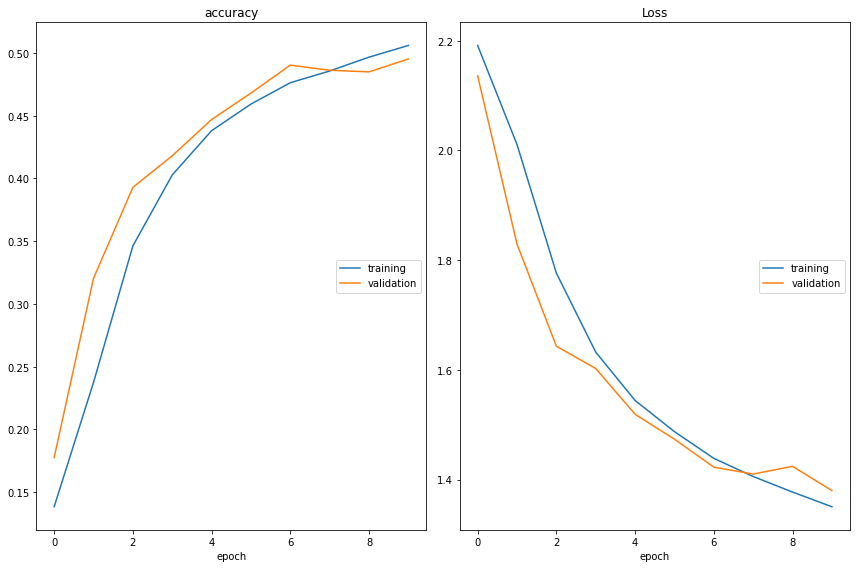

accuracy
	training         	 (min:    0.138, max:    0.506, cur:    0.506)
	validation       	 (min:    0.178, max:    0.495, cur:    0.495)
Loss
	training         	 (min:    1.350, max:    2.191, cur:    1.350)
	validation       	 (min:    1.380, max:    2.136, cur:    1.380)


In [ ]:
"""
В случае необходимости обучить данную модель на Вашем устройстве с нуля,
укажите константу EPOCHS равной 21 для воспроизводимости идентичного эксперимента  
"""

EPOCHS = 10
history = model.fit_generator(train_data_gen,
                              epochs=EPOCHS,
                              validation_data=val_data_gen,
                              callbacks=[PlotLossesCallback()])

#### После каждой итерации обучения модели сохранялись на Google Drive

In [ ]:
model.save("/content/gdrive/MyDrive/models/Diploma ML-mid (default)/vgg19/10ep")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/Diploma ML-mid (default)/vgg19/10ep/assets


In [ ]:
model.save("/content/gdrive/MyDrive/models/Diploma ML-mid (default)/vgg19/17ep")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/Diploma ML-mid (default)/vgg19/17ep/assets


In [ ]:
model.save("/content/gdrive/MyDrive/models/Diploma ML-mid (default)/vgg19/21ep")

## Проверка времени инференса модели

#### Загрузка последней версии модели с Google Drive

In [ ]:
model = tf.keras.models.load_model("/content/gdrive/MyDrive/models/Diploma ML-mid (default)/vgg19/21ep")

#### Подготовка изображения и проверка времени инференса на нём

In [ ]:
import numpy as np
import cv2
from imageio import imread

data = np.empty((1, 256, 256, 3))

image = cv2.imread("/content/gdrive/MyDrive/data/Diploma ML-mid/test_kaggle/4914.jpg")
image = cv2.resize(image, (256, 256))
data[0] = image
data = preprocess_input(data)

In [ ]:
%%timeit -n 10 -r 10

predictions = model.predict(data)

10 loops, best of 10: 66.3 ms per loop


## Ускорение модели с TensorRT

#### Импорт библиотеки TensorRT для алгоритмического ускорения модели

In [ ]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt

In [ ]:
converter = trt.TrtGraphConverterV2(input_saved_model_dir='/content/gdrive/MyDrive/models/Diploma ML-mid (default)/vgg19/21ep')
converter.convert() # оптимизация TensorRT
converter.save_model('/content/gdrive/MyDrive/models/Diploma ML-mid (default)/vgg19/saved_model_trt') 
# сохраняем ускоренную модель

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/models/Diploma ML-mid (default)/vgg19/saved_model_trt/assets


In [ ]:
model_trt = tf.keras.models.load_model('/content/gdrive/MyDrive/models/Diploma ML-mid (default)/vgg19/saved_model_trt')

# Warm-up
_=model_trt(np.zeros((1, 128, 128, 3), dtype=np.float32))

##Проверка времени инференса ускоренной модели

#### Подгрузка изображения для проверки времени инференса на ускоренной модели

In [ ]:
import cv2
from imageio import imread
data = np.empty((1, 128, 128, 3))

image = cv2.imread("/content/gdrive/MyDrive/data/Diploma ML-mid/test_kaggle/4914.jpg")
image = cv2.resize(image, (128, 128))
data[0] = image
data = preprocess_input(data).astype('float32')

In [ ]:
%%timeit -n 10 -r 10

predictions = model_trt(data)

10 loops, best of 10: 5.03 ms per loop
